In [386]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from textblob import TextBlob
from loguru import logger
import matplotlib.dates as mdates
import click
import numpy as np
from matplotlib.ticker import MultipleLocator



# Load config & data

In [387]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': 'whatsapp-20250910-235500.parquet',
 'inputpath': 'your-path-here.csv',
 'datetime_format': '%d/%m/%Y, %H:%M:%S',
 'drop_authors': [],
 'logging': {'logdir': 'logs'}}

In [388]:
# Remove default logger and add console sink
logger.remove()
logger.add(sys.stderr, level="INFO")

# Get log directory from config
log_dir = Path(config["logging"]["logdir"]).resolve()
log_dir.mkdir(parents=True, exist_ok=True)  # ensure folder exists

# Build timestamped logfile path
# timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logfile = log_dir / f"logfile-{timestamp}.log"

logfile = log_dir / f"logfile.log"

# Add file sink
logger.add(
    logfile,
    rotation="10 MB",
    retention="30 days",
    compression="zip",
    level="DEBUG",
    enqueue=True
)

logger.info(f"Logging initialized, writing to {logfile}")

2025-09-21 19:01:52.609 | INFO     | __main__:<module>:25 - Logging initialized, writing to /Users/luiginocleofa/1_HU_Post_HBO_AI/DAV/MADS-DAV/notebooks/logs/logfile.log


In [389]:
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

In [390]:
df = pd.read_parquet(datafile)

In [ ]:
def get_monthly_sentiment(df, keyword):
    """Return monthly average sentiment for a given keyword."""

    # logger.info("hallo from get_monthly_sentiment")


    # Filter messages containing the keyword (case-insensitive)
    keyword_df = df[df["message"].str.contains(keyword, case=False)].copy()

        # Log the first few rows
    logger.debug(f"First 5 messages for '{keyword}':\n{keyword_df.head().to_string()}")
    
    if keyword_df.empty:
        print(f"No messages found for keyword '{keyword}'")
        return None
    
                
    # Log first few rows
    # logger.info(f"Preview of messages for '{keyword}':\n{keyword_df.head(10).to_string()}")

    # Compute sentiment polarity using TextBlob (-1 to +1)
    keyword_df["sentiment"] = keyword_df["message"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    # Aggregate monthly (month-end)
    sentiment_trend = (
        keyword_df.set_index("timestamp")
        .resample("ME")
        .mean(numeric_only=True)[["sentiment"]]
    )
    
    # Fill missing months
    full_index = pd.date_range(sentiment_trend.index.min(), sentiment_trend.index.max(), freq="ME")
    sentiment_trend = sentiment_trend.reindex(full_index)
    
    return sentiment_trend


In [392]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

def plot_keywords_sentiment_with_general(df, keywords, colors=None):
    """Plot multiple keyword sentiment trends and a linear regression general trend in a single graph."""
    plt.figure(figsize=(12, 6))
    
    if colors is None:
        colors = ["green", "orange", "blue", "gray", "red"]
    
    all_trends = []

    for kw, color in zip(keywords, colors):
        trend = get_monthly_sentiment(df, kw)
        if trend is not None:
            plt.plot(trend.index, trend["sentiment"], marker="o", color=color, label=kw)
            all_trends.append(trend["sentiment"])
    
    if all_trends:
        # Compute general trend (mean of all keywords, ignoring NaNs)
        general_trend = pd.concat(all_trends, axis=1).mean(axis=1).dropna()
        
        if not general_trend.empty:
            # Fit linear regression line (degree=1 polynomial)
            x = np.arange(len(general_trend))
            coeffs = np.polyfit(x, general_trend.values, 1)
            y_fit = np.polyval(coeffs, x)
            
            plt.plot(general_trend.index, y_fit, color="red", linestyle="--", linewidth=2, label="Algemene trend (regressie)")
    
    # Horizontal neutral line
    plt.axhline(y=0, color="black", linestyle="--", label="Neutral sentiment")
    
    plt.xlabel("Datum")
    plt.ylabel("Gemiddeld sentiment (-1 tot +1)")
    plt.title("Sentiment trends voor meerdere keywords met lineaire regressie als algemene trend")
    plt.legend()
    plt.xticks(rotation=45)

    # Strict y-axis major ticks every 0.02
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(0.02))

    plt.tight_layout()
    plt.show()


In [393]:
# keywords = ["schoon", "camera", "dank"]

# for kw in keywords:
#     plot_sentiment_trend(df, kw)


2025-09-21 19:01:52.723 | INFO     | __main__:get_monthly_sentiment:4 - hallo from get_monthly_sentiment
2025-09-21 19:01:52.801 | INFO     | __main__:get_monthly_sentiment:4 - hallo from get_monthly_sentiment


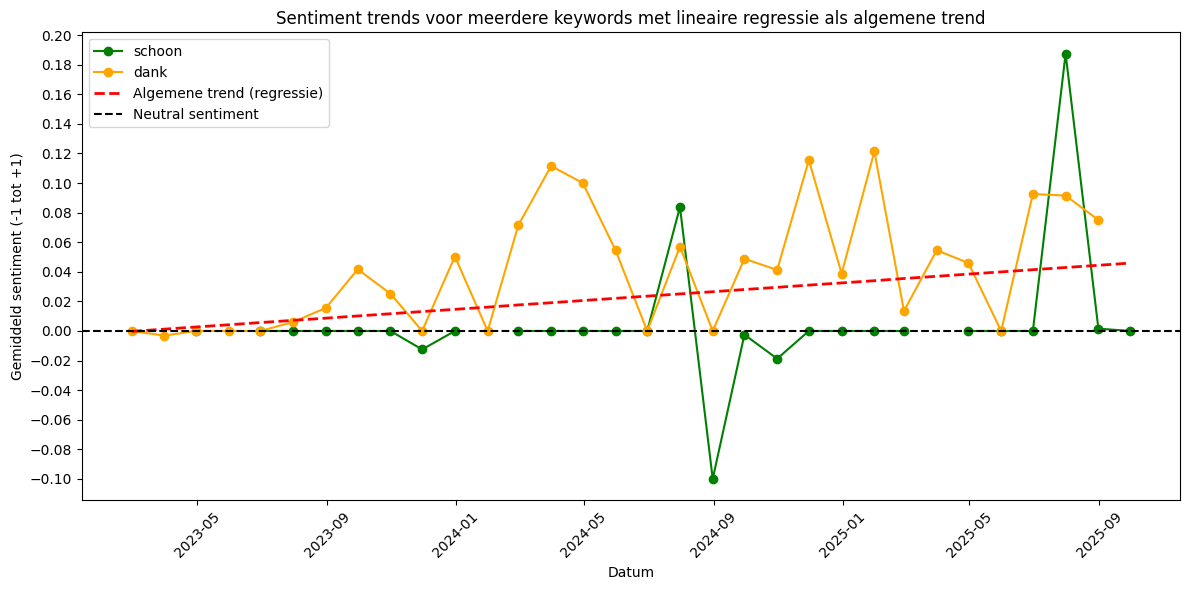

In [394]:
keywords = ["schoon", "dank"]
# plot_keywords_sentiment(df, keywords)
plot_keywords_sentiment_with_general(df, keywords)
